In [ ]:
'''Trains a simple convnet on the MNIST dataset.

Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

# from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

#from keras.optimizers import gradient_descent_v2
#from keras.utils import np_utils
import tensorflow as tf


batch_size = 16
num_classes = 10
epochs = 2

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print(input_shape)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(keras.layers.RandomRotation((-0.05,0.05), fill_mode="nearest"))
model.add(keras.layers.GaussianNoise(0.1))
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

sch = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,
                                                  decay_steps=10000,
                                                  decay_rate=0.9)

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.SGD(learning_rate=sch),
              metrics=['accuracy','Recall','Precision'])

from keras.callbacks import TensorBoard, EarlyStopping
TB = TensorBoard(log_dir='./logs')
ES = EarlyStopping(monitor="val_accuracy", patience=0, restore_best_weights=True)

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[TB, ES])
score = model.evaluate(x_test, y_test, verbose=0)

model.save('my_model.h5')
del model

from keras.models import load_model
model = load_model('my_model.h5')

print('Test loss:', score[0])
print('Test accuracy:', score[1])

(28, 28, 1)
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Epoch 1/2
1215/3750 [========>.....................] - ETA: 1:53 - loss: 0.8824 - accuracy: 0.7170 - recall: 0.5957 - precision: 0.8609

In [ ]:
# ! tensorboard --logdir="./logs"   ## for visualization on your own computer

In [ ]:
model.summary()

import tensorflow as tf
from tensorflow import keras
#keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

#model.weights
#model.weights[0]
#model.weights[0][1][1][0][4]

#print(model.layers)
#print(model.layers[0])
#print(model.layers[7].weights)
#print(model.layers[7].get_weights())
print(model.layers[7].get_weights()[0][0][0])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                        

313/313 [==============================] - 8s 25ms/step
(10000, 10)


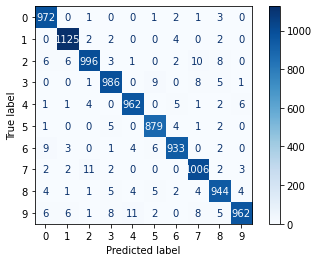

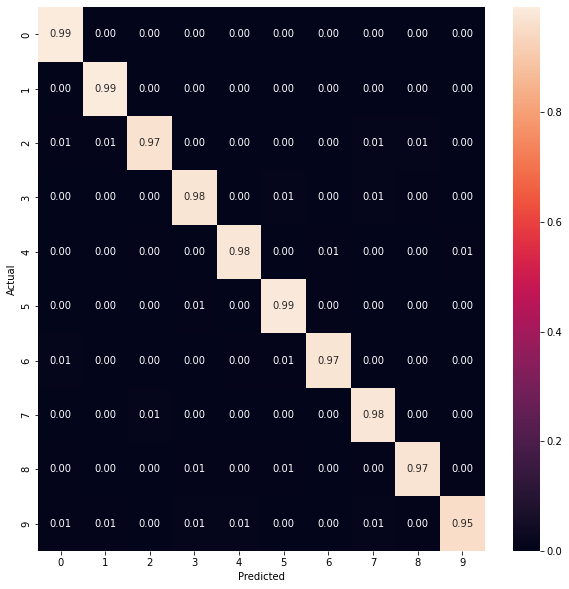

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

y_pred = model.predict(x_test)
print(y_test.shape)
y_pred_plot=np.argmax(y_pred, axis=1)
y_test_plot=np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_plot, y_pred_plot)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

import seaborn as sns
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)
